#### Building and training ConvNet for classifying SIGNS dataset using Tensorflow

1) Implementing helper functions which will be used later when training.
2) Implementing ConvNet using Tensorflow


Lets start by loading packages

In [0]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
import pandas as pd

%matplotlib inline
np.random.seed(1)

Upload training and testing files

In [3]:
from google.colab import files
files.upload()

Saving test_signs.h5 to test_signs.h5
Saving train_signs.h5 to train_signs.h5


Lets load signs dataset

In [0]:
# Function to load the dataset
def load_dataset():
    train_dataset = h5py.File('/content/train_signs.h5', "r")
    
   
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('/content/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [0]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

Lets see some images to get an understanding of data

Image is 0


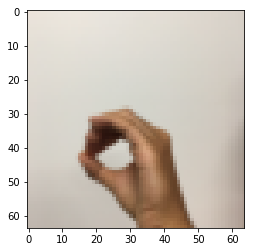

In [7]:
# Example of image
index = 34
plt.imshow(X_train_orig[index])
print('Image is %s' %str(np.squeeze(Y_train_orig[:,34])))

Function to implement one hot encoding of y values

In [0]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

Lets look at shapes of data and normalize them

In [9]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.

Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


#### 1.1 Create placeholders

TensorFlow requires that we create placeholders for the input data that will be fed into the model when running the session.

In [0]:
def create_placeholders(n_H, n_W, n_C, n_Y):
  '''
  Create place holders for tensorflow session
  
  Arguments:
  n_H -- scalar, height of input image
  n_W -- scalar, width of input image
  n_C -- scalar, number of channels in input image
  n_Y -- scalar, number of classes
  
  Returns:
  X -- placeholder for the data input, of shape [None, n_H, n_W, n_C] and dtype 'float'
  Y -- placeholder for the input labels, of shape [None, n_Y] and dtype 'float'
  '''
  
  X = tf.placeholder(dtype = 'float', shape = [None, n_H, n_W, n_C])
  Y = tf.placeholder(dtype = 'float', shape = [None, n_Y])
  
  return X, Y  

#### 1.2 Intialize parameters

Lets intialize parameters for the different channels I will use in convolutional layers. I will be building 2 layers of convolutional layers.

In [0]:
def initialize_parameters():
  '''
  Initializes weight parameters to build a neural network with tensorflow.
  Shapes are W1: [4,4,3,8]
             W2: [2,2,8,16]
             
  Returns -- a dictionary of tensors containing W1, W2
  '''
  tf.set_random_seed(1)                 
  
  W1 = tf.get_variable('W1', [4,4,3,8], initializer=tf.contrib.layers.xavier_initializer(seed = 0))
  W2 = tf.get_variable('W2', [2,2,8,16], initializer=tf.contrib.layers.xavier_initializer(seed = 0))
  
  parameters = {'W1':W1,
                'W2':W2}
  
  return parameters
